# Validation comparing queried articles with random articles

### Sagar Setru, September 21th, 2020

In [1]:
# make sure I'm in the right environment (should be 'debiaser')
import os
print('Conda environment:')
print(os.environ['CONDA_DEFAULT_ENV'])

Conda environment:
debiaser


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import json

# NLP Packages
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# to break articles up into sentences
from nltk import tokenize

import pyLDAvis
import pyLDAvis.gensim

import pickle

# from debiaser_validation_function import return_suggested_articles2
from debiaser.debiaser_validation_function import return_suggested_articles2
from debiaser.debiaser_validation_function import get_jaccard_sim
# from text_processing_functions import process_all_articles
# from text_processing_functions import remove_stopwords
# from text_processing_functions import get_simple_corpus_dictionary_bow
# from text_processing_functions import entity_recognizer
# from text_processing_functions import get_topic_words_mean_std_prob_frequency
# from text_processing_functions import sort_topics_mean_frequency

import pickle
print('DONE')

DONE


/Users/sagarsetru/anaconda3/envs/debiaser/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# these were identified with 5 words

# list of main urls
url_main = [
    'https://www.nytimes.com/2020/09/30/health/covid-cruise-ships.html'
]

urls_queried = [
    'https://abcnews.go.com/Health/wireStory/crew-member-cruise-ship-virus-cases-dies-florida-70073196',
    'https://abcnews.go.com/International/wireStory/german-cruise-ship-sets-sail-hopes-short-trip-71986996',
    'https://apnews.com/article/dbc1f2f76ec33ad06d0a78c4ca3e774a',
    'https://apnews.com/article/ap-top-news-travel-international-news-changing-economy-travel-e9878e281e71d58a6bd4e7f88a24797d',
    'https://www.breitbart.com/news/german-cruise-ship-sets-sail-hopes-short-trip-thwarts-virus/',
    'https://www.forbes.com/sites/alexledsom/2020/09/30/white-house-blocks-cdcs-idea-to-extend-no-sail-order-until-feb-2021/#3e2381e73e42',
    'https://www.foxnews.com/travel/cdc-extends-no-sail-order-cruise-ships-coronavirus-crisis',
    'https://www.foxnews.com/travel/zaandam-cruise-ship-fourth-person-coronavirus-dies',
    'https://www.theguardian.com/us-news/2020/oct/01/florida-keys-cruise-ship-ban-covid-19',
    'https://thehill.com/policy/transportation/518975-white-house-blocked-extending-no-sail-cruise-ship-order-until-february',
    'https://thehill.com/policy/healthcare/486115-second-princess-cruise-ship-with-possible-coronavirus-onboard-held-offshore',
    'https://www.nbcnews.com/health/health-news/live-blog/2020-04-09-coronavirus-news-n1179786/ncrd1180841#blogHeader',
    'https://www.nytimes.com/2020/09/30/health/covid-cruise-ships.html',
    'https://www.nytimes.com/2020/09/30/briefing/presidential-debate-cruise-ships-nba.html',
    'https://www.newsmax.com/world/globaltalk/germany-virus-outbreak-cruises/2020/07/25/id/979000/',
    'https://www.npr.org/sections/coronavirus-live-updates/2020/10/01/919082224/the-cdc-extends-no-sail-order-for-cruise-lines',
    'https://www.npr.org/sections/coronavirus-live-updates/',
    'https://reason.com/video/how-china-corrupted-the-world-health-organizations-response-to-covid-19/',
]

urls_random = [
    'https://abcnews.go.com/Health/wireStory/australia-expects-covid-19-vaccination-year-73467063',
    'https://abcnews.go.com/Politics/wireStory/questions-pence-harris-prepare-debate-faceoff-73458831',
    'https://apnews.com/article/election-2020-virus-outbreak-joe-biden-donald-trump-campaigns-3e201de86931e092efb31de0284ed67e',
    'https://apnews.com/article/virus-outbreak-india-archive-economy-a6b30f224b37015e982fd557dcf522d5',
    'https://www.breitbart.com/economy/2020/10/06/pelosi-killed-the-bill/',
    'https://www.forbes.com/sites/lanabandoim/2020/10/06/tally-the-cute-shelf-scanning-robot-is-coming-to-more-grocery-stores/#6105129e177f',
    'https://www.foxnews.com/sports/patriots-james-white-fathers-tragic-death-meant-whole-lot',
    'https://www.foxnews.com/sports/acuna-hr-plunked-again-braves-top-marlins-9-5-to-open-nlds',
    'https://www.theguardian.com/environment/2020/oct/07/one-guy-pulled-a-crowbar-on-me-why-fly-tipping-wars-are-raging-across-britain',
    'https://thehill.com/policy/energy-environment/519909-biden-would-face-hurdles-undoing-trump-environmental-rollbacks',
    'https://thehill.com/homenews/campaign/519851-trump-biden-tied-when-it-comes-to-economy-poll',
    'https://www.nbcnews.com/news/us-news/justice-department-officials-drove-family-separation-policy-watchdog-report-says-n1242375',
    'https://www.nytimes.com/2020/10/07/nyregion/register-to-vote-nyc.html',
    'https://www.nytimes.com/2020/10/06/nyregion/graffiti-artists-5pointz.html',
    'https://www.newsmax.com/politics/stephen-miller-covid-19-testing-positive/2020/10/06/id/990703/',
    'https://www.npr.org/2020/10/07/921055011/trumps-covid-19-treatment-hangs-over-vice-presidential-debate',
    'https://www.npr.org/2020/10/06/920684113/michelle-obama-makes-final-pitch-vote-for-joe-biden-like-your-lives-depend-on-it',
    'https://reason.com/2020/10/06/eddie-van-halen-melting-pot-virtuoso/',
]

# no hits: aljazeera, atlantic, bbc, buzzfeed, cbn, cbs, democracy now, factcheck, huffpost, national review, reuters, salon

# fails for nearly same event: newsmax, wsj

#     https://nypost.com/2020/04/10/cdc-extends-no-sail-order-for-all-cruises-amid-coronavirus-crisis/
#     https://nypost.com/2020/07/16/cdc-bans-us-cruises-through-september-due-to-ongoing-outbreaks-on-ships/

# doesn't work: CNN, daily beast, msnbc, nypost, spectator
# buggy: mother jones, newsmax, politico, salon

/Users/sagarsetru/anaconda3/envs/debiaser/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# get query words from original article
url_main_query_words = return_suggested_articles2(url_main[0])

# arrays for jaccard sim results
jaccard_sim_queried_articles = np.zeros((len(urls_queried),1))
jaccard_sim_random_articles = np.zeros((len(urls_queried),1))

cosine_sim_queried_articles = np.zeros((len(urls_queried),1))
cosine_sim_random_articles = np.zeros((len(urls_queried),1))

/Users/sagarsetru/anaconda3/envs/debiaser/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AFTER STOPWORDS
[['blocked'], ['cruise', 'ships', 'docked'], [], ['sail', 'extended', 'upset', 'tourism', 'crucial', 'swing', 'florida', 'blocked', 'centers', 'disease', 'prevention', 'cruise', 'ships', 'docked', 'mid', 'displeased', 'politically', 'powerful', 'tourism', 'crucial', 'swing', 'florida', 'sail', 'originally', 'extended', 'expire'], ['dr', 'robert', 'redfield', 'recommended', 'extension', 'worried', 'cruise', 'ships', 'viral', 'hot', 'spots', 'beginning', 'pandemic', 'coronavirus', 'task', 'dr', 'redfield', 'overruled', 'authorized', 'spoke', 'condition', 'anonymity'], ['ships', 'sail', 'oct', 'agreed', 'voluntary'], ['rejection', 'original', 'axios', 'dr'], ['redfield', 'scolded', 'promoting', 'mask', 'wearing', 'cautioning', 'vaccines', 'widely', 'worried', 'fired', 'considered', 'resigning', 'required', 'oversee', 'compromised', 'dr', 'redfield', 'brian', 'morgenstern', 'deputy', 'cruise', 'ship', 'politically', 'motivated'], ['vice', 'task', 'science', 'implement', 'po

In [22]:
# get jaccard sim scores between queried articles and main article

for ind, url in enumerate(urls_queried):
    
    # get query words
    query_words = return_suggested_articles2(url,num_lda_topics=1)
    
    print(f'query words: {query_words[0]}')
    jaccard_sim = get_jaccard_sim(url_main_query_words[1],query_words[1])
        
    jaccard_sim_queried_articles[ind] = jaccard_sim
    
print('DONE')

/Users/sagarsetru/anaconda3/envs/debiaser/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AFTER STOPWORDS
[['crew', 'cruise', 'ship', 'virus', 'cases', 'dies', 'florida'], ['miami', 'crew', 'hospitalized', 'ill', 'fated', 'cruise', 'ships', 'coronavirus', 'patients', 'dock', 'florida', 'broward', 'examiner', 'craig', 'mallak', 'wiwit', 'widarto', 'indonesia'], ['widarto', 'tested', 'positive', 'covid', 'raising', 'zaandam', 'ship', 'coronavirus', 'toll', 'zaandam', 'sister', 'ship', 'docked', 'fort', 'lauderdale', 'port', 'spending', 'sea', 'rejected', 'ports', 'holland', 'erik', 'elvejord'], ['florida', 'ship', 'docked', 'elderly', 'passengers', 'cruise', 'ships', 'arrived', 'examiner', 'tested', 'positive', 'covid'], ['caused', 'viral', 'infection'], ['mallak', 'tested', 'negative', 'virus', 'examined', 'passengers', 'disembarked', 'zaandam', 'sister', 'ship', 'rotterdam', 'replenish', 'supplies', 'crew', 'falling', 'ill'], ['cruise', 'florida', 'negotiated', 'allowing', 'disembarkation', 'cruise', 'passengers', 'kept', 'aboard', 'mildly', 'ill', 'scheduled', 'charter', '

AFTER STOPWORDS
[['blocks', 'cdc', 'extend', 'sail', 'feb'], ['coral', 'princess', 'docked', 'miami', 'passengers', 'crew', 'aboard', 'tested', 'positive', 'covid'], ['cruise', 'sail'], ['disease', 'prevention', 'cdc', 'fighting', 'extend', 'feburary', 'overruled', 'extension', 'extended', 'october', 'pandemic', 'cruise', 'experiencing', 'uk', 'ireland', 'telegraph', 'passenger', 'numbers', 'accounted', 'annually', 'highest', 'eu', 'germany', 'ships', 'launch', 'richard', 'branson', 'scarlet', 'lady', 'costing', 'maiden', 'voyage', 'postponed', 'cdc', 'slammed', 'cruise', 'allowing', 'rapid', 'infection', 'travelers', 'aboard', 'ships', 'pandemic'], ['cdc', 'stated', 'managing', 'outbreaks', 'ships', 'pandemic', 'cruise', 'ships', 'minds', 'carnival', 'diamond', 'princess', 'suffered', 'outbreak', 'infected', 'mooring', 'yokohama', 'harbor', 'japan'], ['operations', 'mostly', 'standstill', 'travelers', 'stranded'], ['carnival', 'quarterly', 'losses', 'mid', 'diamond', 'princess', 'crui

AFTER STOPWORDS
[['blocked', 'extension', 'cdc', 'sail', 'cruise', 'ship'], ['blocked', 'extension', 'centers', 'disease', 'prevention', 'cdc', 'sail', 'cruise', 'ships', 'axios', 'cdc', 'robert', 'redfield', 'reportedly', 'recommended', 'extension', 'expire', 'coronavirus', 'task', 'sources', 'axios', 'redfield', 'ultimately', 'overruled', 'extend', 'oct', 'ships', 'sail', 'reportedly', 'rejection', 'redfield', 'recommendation', 'politically', 'motivated', 'avoid', 'upsetting', 'cruise', 'florida', 'swing', 'polls', 'neck', 'neck', 'race', 'joe', 'bidenjoe', 'bidenmcconnell', 'challenger', 'dodges', 'packing', 'hamilton', 'cast', 'reunite', 'biden', 'fundraiser', 'relishes', 'rallies', 'covid', 'diagnosis', 'timeline', 'aligns', 'cruise', 'voluntary', 'utah', 'gov'], ['leavitt', 'drug', 'commissioner', 'scott', 'gottlieb'], ['gradual', 'normal', 'trips', 'crew', 'acting', 'guests', 'testing', 'guests', 'twice', 'arrival', 'boarding', 'spokesperson', 'brian', 'morganstern', 'axios', 'v

AFTER STOPWORDS
[['blocked'], ['cruise', 'ships', 'docked'], [], ['sail', 'extended', 'upset', 'tourism', 'crucial', 'swing', 'florida', 'blocked', 'centers', 'disease', 'prevention', 'cruise', 'ships', 'docked', 'mid', 'displeased', 'politically', 'powerful', 'tourism', 'crucial', 'swing', 'florida', 'sail', 'originally', 'extended', 'expire'], ['dr', 'robert', 'redfield', 'recommended', 'extension', 'worried', 'cruise', 'ships', 'viral', 'hot', 'spots', 'beginning', 'pandemic', 'coronavirus', 'task', 'dr', 'redfield', 'overruled', 'authorized', 'spoke', 'condition', 'anonymity'], ['ships', 'sail', 'oct', 'agreed', 'voluntary'], ['rejection', 'original', 'axios', 'dr'], ['redfield', 'scolded', 'promoting', 'mask', 'wearing', 'cautioning', 'vaccines', 'widely', 'worried', 'fired', 'considered', 'resigning', 'required', 'oversee', 'compromised', 'dr', 'redfield', 'brian', 'morgenstern', 'deputy', 'cruise', 'ship', 'politically', 'motivated'], ['vice', 'task', 'science', 'implement', 'po

AFTER STOPWORDS
[[], ['berlin', 'german', 'cruise', 'ship', 'gingerly', 'testing', 'amid', 'coronavirus', 'pandemic', 'setting', 'sail', 'shut', 'strict', 'precautions', 'passengers', 'crew', 'safe', 'tui', 'cruise', 'ship', 'mein', 'schiff', 'literally', 'ship', 'sail', 'cruise', 'sea', 'dpa', 'occupancy', 'passengers', 'distance'], ['ship', 'sailed', 'passengers', 'compared', 'normal', 'capacity'], ['crew', 'ship', 'sailed', 'northern', 'port', 'hamburg', 'toward', 'norway', 'passengers', 'spend', 'sea', 'stops', 'returning', 'germany', 'passengers', 'crew', 'required', 'meters', 'feet', 'wear', 'protective', 'masks', 'serve', 'ship', 'buffet'], ['passengers', 'fill', 'questionnaire', 'boarding', 'temperatures', 'shut', 'german', 'cruise', 'ship', 'hoping', 'shorter', 'strictly', 'controlled', 'trips', 'restart', 'devastated', 'pandemic', 'standstill', 'cruise', 'ship', 'suspend', 'operations', 'stranded', 'passengers', 'crew', 'worldwide', 'aug', 'aida', 'cruise', 'operator', 'sail'

TIME FOR LDA MODEL GENERATION
0.7932220000000001
query words:  coronavirus covid vaccine cases pandemic
AFTER STOPWORDS
[['corrupted', 'organization', 'covid'], ['logged', 'zach', 'weissmueller', 'pmthe', 'organization', 'questionable', 'guidance', 'coronavirus', 'slow', 'communicate', 'magnitude', 'threat', 'whitewashed', 'handling', 'crisis', 'funding', 'yesterday', 'absolved', 'failures', 'confronting', 'covid'], ['doubt', 'destroyed', 'credibility', 'damaged', 'contain', 'pandemic', 'actions', 'covid', 'stemmed', 'overly', 'deferential', 'stance', 'contributor'], ['phenomenal', 'collective', 'bruce', 'aylward', 'joint', 'mission', 'handling', 'outbreak', 'tedros', 'adhanom', 'ghebreyesus', 'praised', 'rapid', 'epidemic'], ['praised', 'releasing', 'virus', 'genome', 'neglecting', 'mention'], ['transmission', 'doctors', 'suspected'], ['extreme', 'lockdown', 'wuhan', 'saved', 'scientists', 'weren', 'wuhan', 'outbreak', 'measures', 'interim'], ['praised', 'supposed', 'openness'], ['epi

TIME FOR LDA MODEL GENERATION
1.8184129999999996
query words:  coronavirus virus pandemic taiwan racist
DONE


In [17]:
for ind, url in enumerate(urls_random):
    
    # get query words
    query_words = return_suggested_articles2(url,num_lda_topics=1)
    
    print(f'query words: {query_words[0]}')
    jaccard_sim = get_jaccard_sim(url_main_query_words[1],query_words[1])
    
    jaccard_sim_random_articles[ind] = jaccard_sim
    
print('DONE')

/Users/sagarsetru/anaconda3/envs/debiaser/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AFTER STOPWORDS
[['expects', 'covid', 'vaccination'], ['canberra', 'considered', 'rollout', 'coronavirus', 'vaccine', 'sooner', 'mid', 'scenario', 'pandemic', 'planning', 'save', 'tens', 'billions', 'dollars', 'treasurer', 'treasury', 'departments', 'developed', 'modelling', 'assumption', 'vaccine', 'widely', 'toward', 'treasurer', 'josh', 'frydenberg', 'uncertain', 'vaccine', 'frydenberg', 'treasury', 'modelling', 'contemplate', 'vaccine', 'becoming'], ['vaccine', 'regarded', 'rolled', 'providing', 'certainty', 'households', 'businesses', 'promoting', 'consumption', 'upside', 'scenario', 'assumes', 'universities', 'vaccine'], ['hundreds', 'overseas', 'universities', 'sector', 'earners', 'currency', 'scenario', 'boost', 'activity', 'dollars', 'forecast'], ['percentage', 'fiscal', 'forecast', 'researchers', 'developing', 'covid', 'vaccines'], ['survey', 'mostly', 'canadian', 'vaccinology', 'experts', 'journal', 'internal', 'medicine', 'pessimistic', 'vaccine', 'mid', 'october', 'achieva

AFTER STOPWORDS
[['connection', 'entering', 'rd', 'reopening', 'phase'], ['hartford', 'conn', 'connecticut', 'reopening', 'phase', 'begin', 'milestone', 'coronavirus', 'pandemic', 'lukewarm', 'reception', 'owners', 'arts', 'aficionados', 'restaurant', 'owners', 'capacity', 'limit', 'indoor', 'dining', 'primarily', 'requirement', 'tables', 'feet', 'apart'], ['indoor', 'capacity', 'maximum', 'increased', 'indoor', 'performing', 'arts', 'venues', 'beginning', 'capacity', 'outdoor', 'venues', 'capacity', 'required', 'masks', 'distancing', 'locations'], ['theaters', 'concert', 'venues', 'canceled', 'facilities', 'phase', 'reopening', 'connecticut', 'slight', 'uptick', 'coronavirus', 'cases'], ['hospitalized', 'highest', 'positive', 'virus', 'edged', 'gov'], ['cuomo', 'restrictions', 'parts', 'eli', 'lilly', 'emergency', 'experimental', 'antibody', 'therapy', 'ethics', 'experts', 'treatment', 'experimental', 'covid', 'drug', 'raises', 'fairness', 'condition', 'tennessee', 'returning', 'facil

AFTER STOPWORDS
[['carney', 'nancy', 'pelosi', 'strategy', 'stimulus'], ['nancy', 'pelosi', 'charade', 'pantomime', 'negotiations', 'sometime', 'tranche', 'relief'], ['speaker', 'pelosi', 'treasury', 'steven', 'mnuchin', 'shown', 'neither', 'nor', 'ability', 'aid', 'households', 'agree', 'whatever', 'exact', 'words', 'exchanged', 'pelosi'], ['remained', 'unwavering'], ['enormous', 'democrats', 'pelosi', 'leads', 'reasons', 'oppose', 'aid'], ['improve'], ['improve', 'chances', 'elected'], ['developed', 'ethic', 'pure', 'resistance'], ['bread', 'orange'], ['complex', 'coalition', 'interests', 'democratic', 'electoral', 'succcesses', 'depend', 'upon', 'satisfied', 'spending', 'trillion'], ['picking', 'choosing', 'interests', 'receive', 'funding', 'risks', 'alienating', 'smart', 'choice', 'pelosi', 'script', 'written', 'spring', 'cares'], ['angry', 'pelosi', 'agreeing', 'initial', 'relief', 'legislation', 'refuse', 'negotiate', 'faith', 'speaker', 'nancy', 'pelosi', 'negotiated', 'bipartis

AFTER STOPWORDS
[['acuna', 'hr', 'plunked', 'braves', 'marlins', 'nlds'], ['material', 'broadcast', 'rewritten', 'redistributed'], ['fox', 'llc'], ['reserved'], ['delayed', 'ronald', 'acuna', 'jr', 'leadoff', 'atlanta', 'braves', 'nl', 'division', 'opener', 'miami', 'marlins', 'sandy', 'alcantara', 'fastball', 'hip', 'fired', 'braves', 'fueled', 'comeback', 'woke', 'travis', 'arnaud', 'tiebreaking', 'homer', 'atlanta', 'rally', 'seventh', 'inning'], ['advantage', 'momentum', 'click', 'sports', 'coverage', 'foxnews', 'comd', 'arnaud', 'doubled', 'singled', 'driving', 'runs', 'dansby', 'swanson', 'homered', 'comeback', 'atlanta', 'shutting', 'cincinnati', 'innings', 'sweep', 'wild', 'card', 'braves', 'relied', 'bats', 'opener'], ['houston', 'acuna', 'braves', 'bottom', 'alcantara', 'pitch', 'homer'], ['watched', 'flipping', 'bat', 'rounding', 'bases', 'youngest', 'postseason', 'leadoff', 'testy', 'acuna', 'nailed', 'mph', 'fastball'], ['showy', 'outfielder', 'onto', 'bat', 'walked', 'ste

TIME FOR LDA MODEL GENERATION
0.2750479999999982
query words:  fly tipping rubbish tippers hamilton
AFTER STOPWORDS
[['biden', 'hurdles', 'undoing', 'environmental', 'rollbacks'], ['democratic', 'nominee', 'joe', 'bidenjoe', 'bidenmcconnell', 'challenger', 'dodges', 'packing', 'hamilton', 'cast', 'reunite', 'biden', 'fundraiser', 'relishes', 'rallies', 'covid', 'diagnosis', 'elected', 'aim', 'rollbacks', 'environmental', 'protections', 'biden', 'climate', 'lays', 'actions', 'implementing', 'aggressive', 'methane', 'pollution', 'limits', 'oil', 'gas', 'sector', 'developing', 'rigorous', 'fuel', 'standards', 'environmental', 'advocates', 'vice', 'target', 'effects', 'climate', 'harmful', 'marginalized', 'communities', 'complexities', 'rulemaking', 'structural', 'implemented', 'undoing', 'environmental', 'rollbacks', 'reverse', 'environmental', 'analysis'], ['replacing', 'era', 'clean', 'rule', 'reduced', 'regulatory', 'burdens', 'coal', 'fired', 'plants', 'slashing', 'mileage', 'emission

AFTER STOPWORDS
[['deadlines'], ['daniel', 'slotnik'], [], ['weather', 'hat', 'blustery', 'gusts'], ['sun', 'scattered', 'shower', 'mid', 'alternate', 'parking', 'effect', 'shemini', 'atzereth'], ['amended', 'regulations', 'pandemic', 'upends', 'usual', 'crucial', 'mundane', 'civic', 'duty', 'voting'], ['yorkers', 'unaware', 'deadlines', 'register', 'request', 'absentee', 'ballot', 'voters', 'cast', 'mail', 'ballots', 'erroneous', 'absentee', 'ballots', 'brooklyn'], ['mishap', 'fodder', 'false', 'mail', 'corrupt', 'voting'], ['consult', 'guide', 'counted', 'oct'], ['yorkers', 'register', 'mail', 'oct'], ['elections', 'receive', 'mailed', 'registration', 'request'], ['forms', 'postmarked', 'oct', 'oct'], ['voters', 'request', 'absentee', 'ballots', 'fax', 'mail', 'elections', 'nov'], ['voters', 'apply', 'absentee', 'ballot', 'nov'], [], ['absentee', 'ballots', 'postmarked'], [], [], ['register', 'elections', 'variety', 'agencies', 'motor', 'vehicles', 'offices', 'mail', 'voter', 'regist

TIME FOR LDA MODEL GENERATION
0.11314300000000088
query words:  pence debate harris liasson biden
AFTER STOPWORDS
[['michelle', 'pitch', 'joe', 'biden', 'depend'], ['continues', 'gaslight', 'acting', 'pandemic', 'threat', 'michelle', 'remarks'], ['screenshot', 'biden', 'youtube', 'hide', 'continues', 'gaslight', 'acting', 'pandemic', 'threat', 'michelle', 'remarks', 'lady', 'michelle', 'excoriated', 'aimed', 'delivering', 'closing', 'argument', 'voters', 'elect', 'joe', 'biden'], ['pretend', 'exactly', 'stands'], ['search', 'hearts', 'conscience', 'joe', 'biden', 'depend', 'biden', 'rebuked', 'sees', 'willful', 'mismanagement', 'covid', 'crisis'], ['wear', 'mask', 'consistently', 'encourage', 'actions', 'save', 'countless'], ['continues', 'gaslight', 'acting', 'pandemic', 'threat'], ['remarks', 'discharged', 'walter', 'reed', 'receive', 'treatment', 'covid', 'upon', 'mask', 'op', 'downplayed', 'severity', 'virus'], ['afraid'], ['beat', 'admonished', 'push', 'colleges', 'reopen'], ['eve

TIME FOR LDA MODEL GENERATION
0.34405299999999883
query words:  halen van eddie guitar rock
DONE


/Users/sagarsetru/anaconda3/envs/debiaser/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


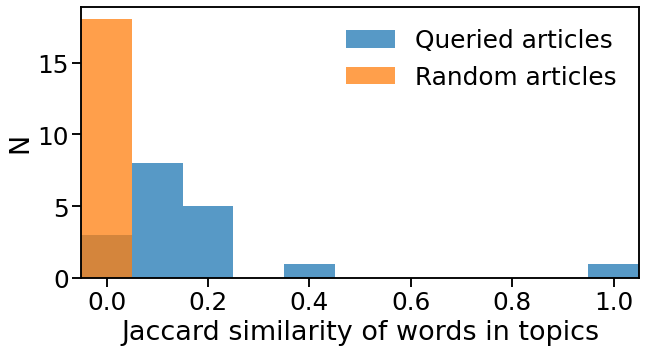

<Figure size 432x288 with 0 Axes>

In [23]:
plt.figure(figsize=(10,5));
plt.hist(jaccard_sim_queried_articles,bins=np.arange(0,1.2,.1)-.05,alpha=0.75);
plt.hist(jaccard_sim_random_articles,bins=np.arange(0,1.2,.1)-.05,alpha=0.75);
plt.ylabel('N');
plt.xlabel('Jaccard similarity of words in topics')
sns.set_context('talk', font_scale=1.5);
plt.xlim([-.05,1.05])
plt.legend(('Queried articles','Random articles'),framealpha=0)
# plt.xticks(rotation=90);
plt.show();
plt.clf();

We see that the queried articles tend to have more similar topic words, as measured by Jaccard similarity, to the initial article than random articles.